In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2 as cv
from osgeo import gdal
import netCDF4
import tqdm
from scipy.spatial import ckdtree
plt.ion()
import xml.etree.ElementTree as ET
import scipy.io as io

import cv2 as cv
import matplotlib.pyplot as plt
plt.ion()
import os
import glob
import matplotlib.colors as colors
import numpy as np
import shapefile
import gdal
import gzip
import shutil
import tqdm
import os

In [2]:
def unzip_and_write(filepath):
    if filepath[-2:] == 'gz':
        with gzip.open(filepath, 'rb') as f_in:
            with open(filepath[:-2], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [3]:
# under WGS84 Assumption
# "a"
semiMajor = 6.378137000000000e+06
# "b"
semiMinor = 6.356752314245179e+06
# "Rnear"
slant = 8.436862401575363e+05
groundOrigin = 0

In [7]:
# land_mask = io.loadmat('landmaskna.mat')
# land_mask_val = land_mask['landnafp']
# land_mask_flat_lat = land_mask['latvalsna'].flatten()
# land_mask_flat_lon = land_mask['lonvalsna'].flatten()
# # land_mask_xyz = np.zeros([len(land_mask_flat_lat)*len(land_mask_flat_lon), 3])
# # count = 0
# # for lon in tqdm.tqdm(land_mask_flat_lon):
# #     for lat in land_mask_flat_lat:
# #         land_mask_xyz[count] = cart_transform(lat, lon)
# #         count = count + 1
        
# land_lat_fit = np.poly1d(np.polyfit(land_mask_flat_lat,range(0, len(land_mask_flat_lat)), 1))
# land_lon_fit = np.poly1d(np.polyfit(land_mask_flat_lon, range(0, len(land_mask_flat_lon)), 1))

In [4]:
def cart_transform(phi, lam):
    phi_rad = np.pi * phi/180
    lam_rad = np.pi * lam/180
    den = np.sqrt(semiMajor*semiMajor*np.cos(phi_rad)*np.cos(phi_rad) + semiMinor*semiMinor*np.sin(phi_rad)*np.sin(phi_rad))    
    Xuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.cos(lam_rad))/den
    Yuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.sin(lam_rad))/den
    Zuv = (semiMinor*semiMinor*np.sin(phi_rad))/den
    return (Xuv, Yuv, Zuv)

def cart_inv(x,y,z):
    phi_rad = np.arctan(semiMajor*z/(semiMinor*np.sqrt(semiMinor*semiMinor - z*z)))
    lam_rad = np.arctan2(y,x)
    phi = 180*phi_rad/(np.pi)
    lam = 180*lam_rad/(np.pi)
    return phi, lam

def idw(distances):
    if np.count_nonzero(distances) != len(distances):
        weights = np.zeros_like(distances)
        weights[0] = 1
    else:
        inverse_sum = sum([1/d for d in distances])
        weights = (1/distances)/inverse_sum
    return weights

In [5]:
def concentration(lat, lon):
    
    '''
    Given a lat-lon pair interpolate using IDW to find the actual concentration
    '''
    land_pos_y = int(np.round(land_lon_fit(lon)))
    land_pos_x = int(np.round(land_lat_fit(lat)))
    
    land_val = land_mask_val[land_pos_x,land_pos_y]
    
    if not np.isnan(land_val):
        return np.nan
    else:
        return 1
#     dists, idxs = tree.query((lat, lon), samples)
#     concentration_values = np.array([chart_data_flat[i] for i in idxs])
#     nan_vals = np.isnan(concentration_values)
#     if any(nan_vals):
#         return np.nan
#     try:
#         weights = idw(dists)
#     except:
#         weights = 1
#         return chart_data_flat[idxs]
#     return np.sum(np.multiply(concentration_values, weights))

In [6]:
def concentration_Z(x, y):
    
    '''
    Given a lat-lon pair interpolate using IDW to find the actual concentration
    '''
    land_pos_y = int(np.round(land_lon_fit(lon)))
    land_pos_x = int(np.round(land_lat_fit(lat)))
    
    land_val = land_mask_val[land_pos_x,land_pos_y]
    
    if not np.isnan(land_val):
        return np.nan
    else:
        return 1

In [7]:
def gen_conc_image(geotiff_path, DOWN_RATE=16):
    dataset = gdal.Open(geotiff_path, gdal.GA_ReadOnly)

    image_shape = [np.round(dataset.RasterYSize/DOWN_RATE).astype(np.int), np.round(dataset.RasterXSize/DOWN_RATE).astype(np.int)]
    print(image_shape)
    
    control_pts = dataset.GetGCPs()
    control_pixel_locations = [(pt.GCPLine/DOWN_RATE, pt.GCPPixel/DOWN_RATE) for pt in control_pts]
    control_tree = ckdtree.cKDTree(control_pixel_locations)
    
    SAMPLES = 4
    pos_values = [cart_transform(pt.GCPY, pt.GCPX) for pt in control_pts]
    concentration_image = np.zeros((image_shape))
    lat_lon_image = np.zeros((image_shape[0], image_shape[1], 2))
    for i in (range(concentration_image.shape[0])):
        for j in range(concentration_image.shape[1]):
            distances, indices = control_tree.query((i, j), SAMPLES)
            weights = idw(distances)
            X_values = [pos_values[index][0] for index in indices]
            Y_values = [pos_values[index][1] for index in indices]
            Z_values = [pos_values[index][2] for index in indices]
            X = np.sum(np.multiply(X_values, weights))
            Y = np.sum(np.multiply(Y_values, weights))
            Z = np.sum(np.multiply(Z_values, weights))
#             conc_Z = concentration_Z(XYZ_tree, X,Y,Z, chart_data_flat)
            lat, lon = cart_inv(X,Y,Z)
            lat_lon_image[i,j,0] = lat 
            lat_lon_image[i,j,1] = lon
            conc = concentration(lat, lon)
            concentration_image[i, j] = conc
    
    return concentration_image, lat_lon_image

In [40]:
latlon_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\latlon_data_normal\\"
outlat_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\latlon_data_revised\\"
results_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\prime-large"
for subfolder in glob.glob(os.path.join(latlon_folder, '*')):
    ty = os.path.basename(subfolder)
    results = glob.glob(os.path.join(results_folder, ty, 'bigger_*.tiff'))
    for result in tqdm.tqdm(results):
        res = cv.imread(result, 0)
        shape = res.shape
        des = os.path.basename(result)[len('bigger_'):-len('.tiff')]
        geo_folder = glob.glob(os.path.join('c:/Users/clvco/URA_W18/data_val/**/', '*' + des + '*'))[0]
        files = glob.glob(os.path.join(hh_folder, '*.tif'))
        files = sorted(files, key=os.path.getsize)
        geo_path = files[-1]
        assert os.path.exists(geo_path)
        conc, latlon_image = gen_conc_image(geo_path)
        latlon_image = cv.resize(latlon_image, shape[::-1])
        np.savetxt(os.path.join(outlat_folder, ty, 'lat_' + des + '.txt'), latlon_image[:,:,0])
        np.savetxt(os.path.join(outlat_folder, ty, 'lon_' + des + '.txt'), latlon_image[:,:,1])
        

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

[611, 659]


  8%|██████▍                                                                            | 1/13 [00:54<10:55, 54.66s/it]

[541, 656]


 15%|████████████▊                                                                      | 2/13 [01:42<09:24, 51.33s/it]

[442, 657]


 23%|███████████████████▏                                                               | 3/13 [02:22<07:53, 47.36s/it]

[620, 659]


 31%|█████████████████████████▌                                                         | 4/13 [03:17<07:25, 49.46s/it]

[634, 660]


 38%|███████████████████████████████▉                                                   | 5/13 [04:16<06:49, 51.21s/it]

[567, 658]


 46%|██████████████████████████████████████▎                                            | 6/13 [05:07<05:59, 51.31s/it]

[629, 660]


 54%|████████████████████████████████████████████▋                                      | 7/13 [06:04<05:12, 52.09s/it]

[634, 661]


 62%|███████████████████████████████████████████████████                                | 8/13 [07:02<04:24, 52.80s/it]

[629, 660]


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [08:00<03:33, 53.40s/it]

[176, 656]


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [08:16<02:29, 49.69s/it]

[516, 655]


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [09:03<01:38, 49.44s/it]

[458, 656]


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [09:45<00:48, 48.76s/it]

[576, 659]


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[632, 661]


 10%|████████▎                                                                          | 1/10 [00:58<08:44, 58.27s/it]

RS2_OK44067_PK425720_DK376088_SCWA_20130910_131728_HH_HV_SGF
[622, 658]


 30%|████████████████████████▉                                                          | 3/10 [01:55<04:29, 38.45s/it]

[628, 658]


 40%|█████████████████████████████████▏                                                 | 4/10 [02:53<04:20, 43.37s/it]

RS2_OK44073_PK425834_DK376182_SCWA_20130913_132853_HH_HV_SGF


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:53<02:53, 34.73s/it]

[628, 658]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:53<02:35, 38.98s/it]

RS2_OK44073_PK425837_DK376185_SCWA_20130913_151015_HH_HV_SGF


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:54<01:40, 33.43s/it]

[628, 662]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:51<01:12, 36.44s/it]

[632, 658]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:47<00:38, 38.64s/it]

RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:47<00:00, 34.80s/it]


In [8]:
im_folders = [
    '20090322',
'20100125',
'20100131',
'20100403',
'20100405',
'20101005',
'20101007',
'20101009',
'20101013',
'20101014',
'20101205',
'20101213',
'20101221',
'20110213',
'20110214',
'20110216',
'20110217',
'20110220',
'20110223',
'20110319',
'20110405',
'20110627',
'20110702',
'20110705',
'20110717',
'20110730',
'20110731',
'20110903',
'20090322B',
'20100125B',
'20100131B',
'20101009B',
'20110627B',
'20110717B',
'20110717C',
'20110903B',
'20110903C',
'20110903D'
]

In [22]:
control_pts[0].GCPX

-65.52899254263002

In [72]:
base_path = 'C:/Users/clvco/URA_W18/training_data/'
out_folder = 'C:/Users/clvco/Google Drive/3B/URA/final_results/downsampled_images'
folders = [os.path.join(base_path, imf) for imf in im_folders]
mean_lats = []
mean_lons = []
folders = [f for f in folders if '0322B' in f]

for folder in folders:
    try:
        files = glob.glob(os.path.join(folder, '*H*.tif'))[0]
        hh_file = cv.imread(files,0)
        
        hh_down = cv.resize(hh_file, (1000,240))
        out_path = os.path.join(out_folder, os.path.basename(folder) + '.tiff')
        cv.imwrite(out_path, hh_down)
    except:
        print(folder)


In [70]:
hh_file.shape

(2421, 10475)

In [68]:
folders

['C:/Users/clvco/URA_W18/training_data/20090322B']

In [64]:
out_path

'C:/Users/clvco/Google Drive/3B/URA/final_results/downsampled_images\\20090322.tiff'

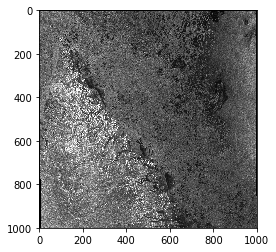

In [57]:
plt.imshow(hh_down, plt.cm.gray)

'C:/Users/clvco/URA_W18/training_data/20110903D\\imagery_HH.tif'

In [50]:
folder



'C:/Users/clvco/URA_W18/training_data/20100125'

In [44]:
files

['C:/Users/clvco/URA_W18/training_data/20110903D\\imagery_HH.tif']

In [40]:
for lat, lon in zip(mean_lats, mean_lons):
    print(lat,'$', lon,'$', lat,',',lon)

58.6867437285 $ -61.5892524709 $ 58.6867437285 , -61.5892524709
60.1221893812 $ -57.8765912092 $ 60.1221893812 , -57.8765912092
48.6497520578 $ -67.8958663917 $ 48.6497520578 , -67.8958663917
70.6407480444 $ -132.099536306 $ 70.6407480444 , -132.099536306
71.1012905768 $ -142.267956847 $ 71.1012905768 , -142.267956847
69.4443281412 $ -96.4835964027 $ 69.4443281412 , -96.4835964027
72.7277455761 $ -116.709960441 $ 72.7277455761 , -116.709960441
71.2853229769 $ -78.0601800927 $ 71.2853229769 , -78.0601800927
68.9412242388 $ -100.730863377 $ 68.9412242388 , -100.730863377
73.9241891256 $ -116.995928337 $ 73.9241891256 , -116.995928337
60.9223092426 $ -93.2717037383 $ 60.9223092426 , -93.2717037383
73.0091525904 $ -77.6292224108 $ 73.0091525904 , -77.6292224108
44.3812828196 $ -81.6121301645 $ 44.3812828196 , -81.6121301645
60.0753659972 $ -57.8996581284 $ 60.0753659972 , -57.8996581284
54.8047314841 $ -52.4240375153 $ 54.8047314841 , -52.4240375153
57.2870744446 $ -62.1063402396 $ 57.2870

In [31]:
mean_lats

[58.686743728458836]

In [32]:
mean_lons

[-61.589252470931093]

In [29]:
folders[0]

'C:/Users/clvco/URA_W18/training_data/20090322'

In [25]:
xs

[-65.52899254263002,
 -64.5530738490794,
 -63.58114712818004,
 -62.61355830168902,
 -61.65073696854972,
 -60.69312870337794,
 -59.74113741600578,
 -58.79508599658033,
 -57.85520561126911,
 -56.92167887032296,
 -55.99480795699436,
 -65.64692505689322,
 -64.68456719378152,
 -63.72607012496669,
 -62.77176068043667,
 -61.82204887262372,
 -60.87736125755581,
 -59.93808416269962,
 -59.00452488607759,
 -58.0769010971599,
 -57.15538334324464,
 -56.24026082641264,
 -65.76337409570493,
 -64.8141548026262,
 -63.86867203337238,
 -62.92723469480094,
 -61.9902343697299,
 -61.05807970969607,
 -60.13114051239109,
 -59.20970947636367,
 -58.2939917413915,
 -57.3841468291511,
 -56.4804523048246,
 -65.87843708236541,
 -64.94195092552255,
 -64.0090832407876,
 -63.08012603950868,
 -62.15545347300338,
 -61.23545721703272,
 -60.32049136272205,
 -59.41083469509834,
 -58.50668034219222,
 -57.60817711144494,
 -56.71559096753276,
 -65.99214902269357,
 -65.06800888473927,
 -64.1473751080016,
 -63.2305238026072,
 -

In [15]:
control_pts

(<osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E870> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045EC90> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E6F0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E7B0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E7E0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E780> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E930> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045EA50> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E9F0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E900> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of type 'GDAL_GCP *' at 0x000001770045E8D0> >,
 <osgeo.gdal.GCP; proxy of <Swig Object of 

In [13]:
os.listdir(folders[0])

['ArcticZoom_asi-n3125-20090322.tif',
 'asi-n6250-20090322-v5.nc',
 'conc.tiff',
 'imagery_HH.tif',
 'LongitudeLatitudeGrid-n3125-ArcticZoom.nc',
 'lutBeta.xml',
 'lutGamma.xml',
 'lutSigma.xml',
 'product.xml',
 'RS2_OK4491_PK59492_DK57897_SCWA_20090322_102729_HH',
 'RS2_OK4491_PK59492_DK57897_SCWA_20090322_102729_HH(1)',
 'RS2_OK4491_PK59492_DK57897_SCWA_20090322_102729_HH.tif']